In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import healpy as hp

from Qatmosphere_2d import AtmosphereMaps

import sys
import yaml

sys.path.append('/home/laclavere/qubic/qubic/Pipeline')

import qubic

from qubic.scripts.MapMaking.src.FMM.model.planck_timeline import InputMaps
from qubic.lib.Qcg import PCGAlgorithm
from pyoperators.iterative.core import AbnormalStopIteration

from pyoperators import *

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

%matplotlib inline

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
# Import simulation parameters
with open('params.yml', 'r') as file:
    params = yaml.safe_load(file) 

In [3]:
# Call the class which build the atmosphere maps
atm = AtmosphereMaps(params)

(0.0, 0.0002)

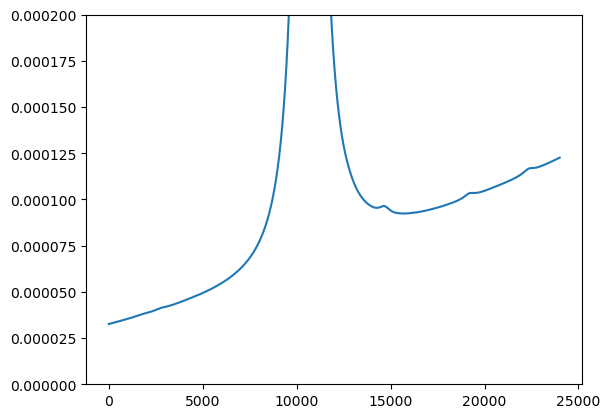

In [4]:
# Import the atm absorption spectrum
abs_spectrum = atm.absorption_spectrum()

plt.plot(abs_spectrum)
plt.ylim(0, 0.0002)

In [5]:
# Import the atm temperature maps
atm_maps = atm.get_temp_maps(atm.rho_map)
print(atm_maps.shape)

# Import the atm integrated absorption spectrum
integrated_abs_spectrum, frequencies = atm.integrated_absorption_spectrum()

(20, 196608)


Text(0, 0.5, 'Integrated absorption spectrum')

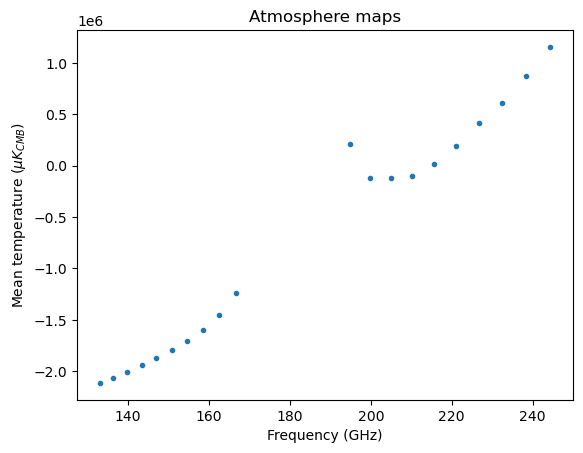

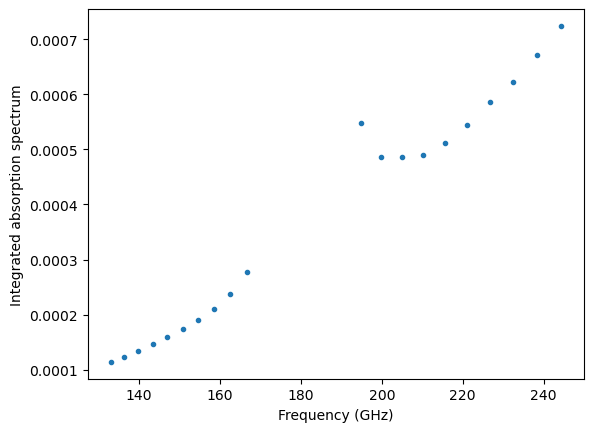

In [6]:
mean_atm_maps = []
for i in range(atm_maps.shape[0]):
    mean_atm_maps.append(np.mean(atm_maps[i, :]))
plt.figure()
plt.plot(frequencies, mean_atm_maps, '.')
plt.title('Atmosphere maps')
plt.xlabel('Frequency (GHz)')
plt.ylabel(r'Mean temperature ($\mu K_{CMB}$)')
plt.figure()
plt.plot(frequencies, integrated_abs_spectrum, '.')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Integrated absorption spectrum')

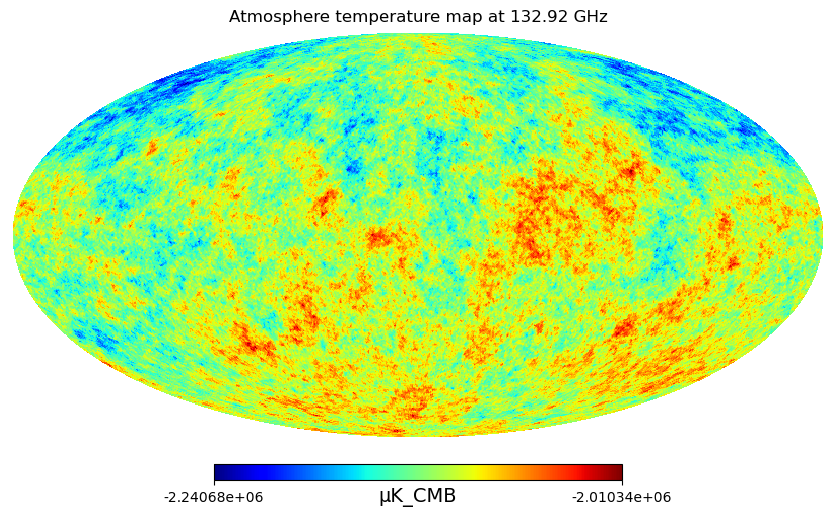

In [7]:
hp.mollview(atm_maps[0], title='Atmosphere temperature map at {:.2f} GHz'.format(frequencies[0]), cmap='jet', unit='µK_CMB')

(20, 196608, 3)


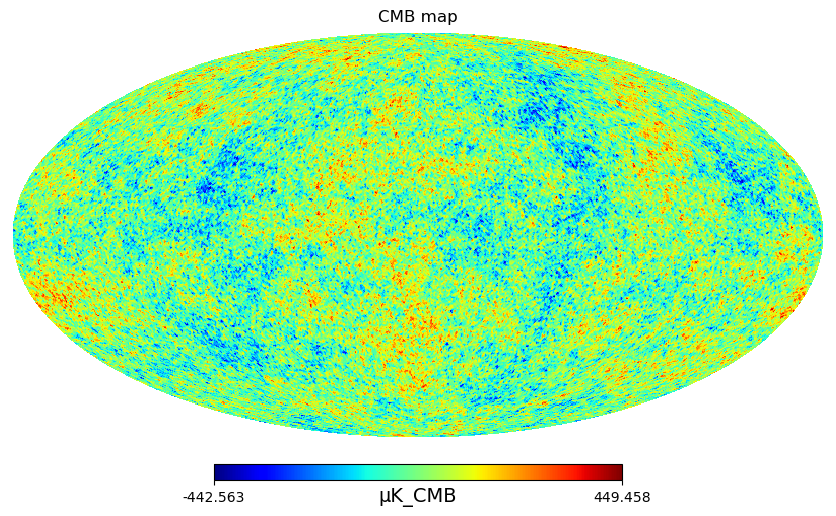

In [8]:
# Import CMB maps
cmb_maps = InputMaps({'cmb':42}, atm.frequencies, 2, params['nside']).m_nu
print(cmb_maps.shape)
hp.mollview(cmb_maps[-1, :, 0],cmap='jet', unit='µK_CMB', title='CMB map')

(196608,)


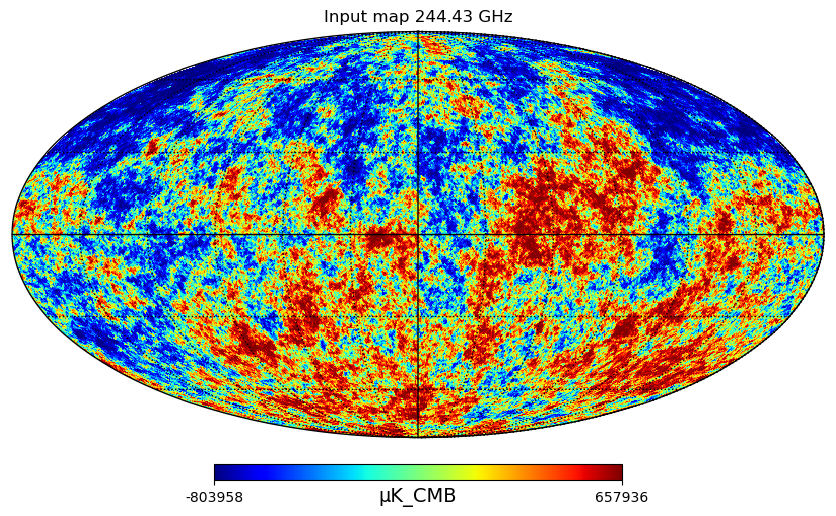

In [9]:
# Build input maps : CMB + Atmsophere (only for I map)
input_maps = cmb_maps.copy() * 0
input_maps[:, :, 0] += atm_maps
print(input_maps[0, :, 0].shape)
for irec in range(input_maps.shape[0]):
    input_maps[irec, :, 0] -= np.mean(input_maps[irec, :, 0])

hp.mollview(input_maps[-1, :, 0] ,cmap='jet', unit='µK_CMB', norm='hist', title='Input map {:.2f} GHz'.format(frequencies[-1]))
hp.graticule()

(2, 196608, 3)
[149.22332137 218.86087134]


(130.0, 250.0)

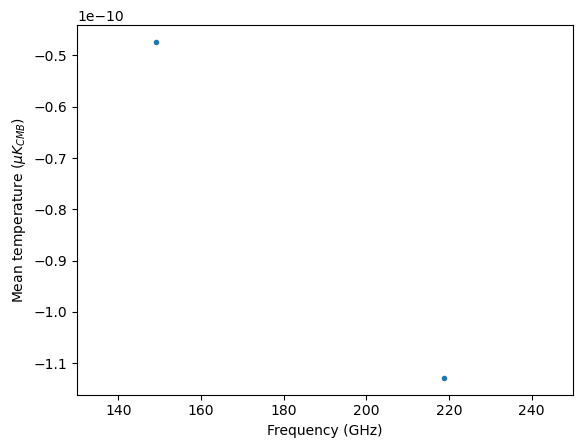

In [10]:
# Compute the Nrec maps from the Nsub maps
true_maps = np.zeros((params['nrec'], 12*params['nside']**2, 3))
true_frequencies = np.zeros(params['nrec'])
fsub = int(params['nsub_in'] / params['nrec'])
for i in range(params['nrec']):
    true_maps[i, :, :] = np.mean(input_maps[i*fsub:(i+1)*fsub, :, :], axis=0)
    true_frequencies[i] = np.mean(frequencies[i*fsub:(i+1)*fsub])
print(true_maps.shape) 
print(true_frequencies)   
plt.plot(true_frequencies, np.mean(true_maps, axis=1)[..., 0], '.')
plt.ylabel(r'Mean temperature ($\mu K_{CMB}$)')
plt.xlabel('Frequency (GHz)')
plt.xlim(130, 250)

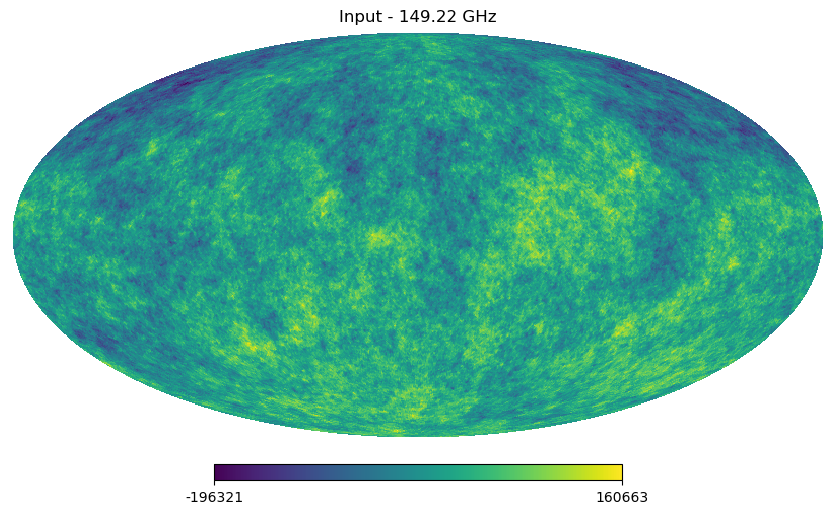

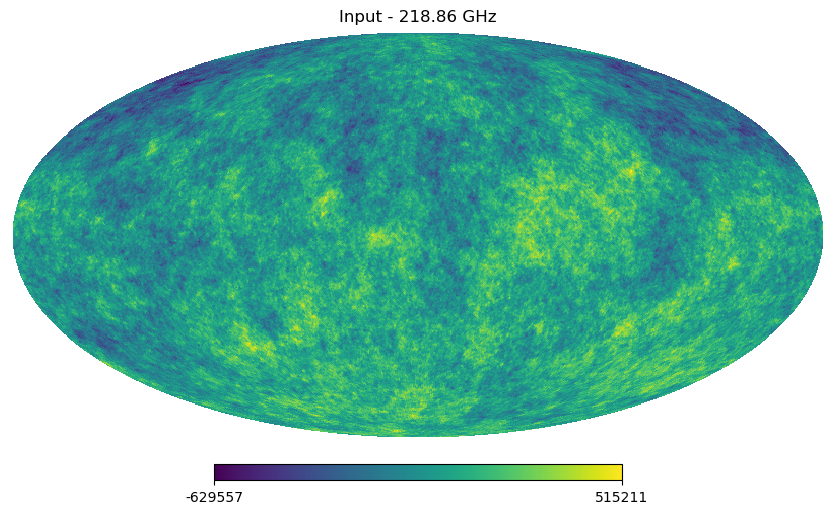

In [11]:
for inu in range(len(true_frequencies)):
    hp.mollview(true_maps[inu, :, 0],title='Input - {:.2f} GHz'.format(true_frequencies[inu]))

# Map-making

In [12]:
#coverage = joint.qubic.subacqs[0].get_coverage()


In [13]:
# Build the QUBIC operators
H_tod_qubic = qubic.lib.InstrumentModel.Qacquisition.QubicDualBand(atm.qubic_dict, nsub=params['nsub_in'], nrec=params['nsub_in']).get_operator()
Qacq = qubic.lib.InstrumentModel.Qacquisition.QubicDualBand(atm.qubic_dict, nsub=params['nsub_in'], nrec=params['nrec'])
H_rec_qubic = Qacq.get_operator().operands[1]
invN_qubic = Qacq.get_invntt_operator()
tod_qubic = H_tod_qubic(input_maps).ravel()

You asked 2000 pointings with repeat strategy so I will provide 666 pointings repeated 3 times.
Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMat

In [14]:
coverage = Qacq.coverage

covnorm = coverage / coverage.max()
seenpix = covnorm > params['coverage_cut']

center = np.array([0, -57])
qubic_patch = qubic.lib.Qsamplings.equ2gal(center[0], center[1])

In [15]:
print('H_rec', H_rec_qubic.shapein, H_rec_qubic.shapeout)
print('invN', invN_qubic.shapein, invN_qubic.shapeout)
print('H_tod', H_tod_qubic.shapein, H_tod_qubic.shapeout)

H_rec (2, 196608, 3) (2, 992, 1998)
invN (1984, 1998) (1984, 1998)
H_tod (20, 196608, 3) (1984, 1998)


In [16]:
H_tod = H_tod_qubic
R = ReshapeOperator(H_rec_qubic.shapeout, invN_qubic.shapein)
H_rec = R(H_rec_qubic)
invN = invN_qubic
tod = tod_qubic

In [17]:
print('H_rec_qubic', H_rec_qubic.shapein, H_rec_qubic.shapeout)
print("H_rec", H_rec.shapein, H_rec.shapeout)
print("invN", invN.shapein, invN.shapeout)
print('invN qubic', invN_qubic.shapein, invN_qubic.shapeout)
print("TOD", tod.shape)

H_rec_qubic (2, 196608, 3) (2, 992, 1998)
H_rec (2, 196608, 3) (1984, 1998)
invN (1984, 1998) (1984, 1998)
invN qubic (1984, 1998) (1984, 1998)
TOD (3964032,)


In [18]:
# Build PCG
R = ReshapeOperator(tod.shape, invN_qubic.shapein)
A = H_rec.T * invN * H_rec
b = H_rec.T * invN * R(tod)
x0 = true_maps*0

In [19]:
H_rec.operands[1].operands[0].operands[0]

CompositionOperator([
    ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,1998), shapeout=(992,1998)),
    DiagonalOperator(array([0.0003231794364018645, ..., 0.0003231794364018645], dtype=float64), broadcast='rightward', None),
    ReshapeOperator((992,1998,1), (992,1998), None),
    DenseBlockDiagonalOperator(array([[[[5.1327998155501615e-21, ..., -4.445135032806519e-21]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,1998,3), shapeout=(992,1998,1)),
    ProjectionOperator(None, None, shapein=(196608,3), shapeout=(992,1998,3))])

In [20]:
stacked_dptdp_inv = np.zeros((len(H_rec.operands),12*params['nside']**2))
for i in range(len(H_rec.operands)):
    H_single = H_rec.operands[1].operands[i].operands[0]
    D = H_single.operands[1]
    P = H_single.operands[-1]
    sh = P.matrix.data.index.shape
    no_det = 992
    
    point_per_det = int(sh[0] / no_det)
    mapPtP_perdet_seq = np.zeros((no_det,12*params['nside']**2))
    for det in range(no_det):
        mapPitPi = np.zeros(12*params['nside']**2)
        for peak in range(sh[1]):
            for sample in range(det*point_per_det, (det+1)*point_per_det):
                mapPitPi[P.matrix.data.index[sample,peak]] += P.matrix.data.r11[sample,peak]**2
        mapPtP_perdet_seq[det,:] = mapPitPi

    D_elements = D.data
    D_sq = D_elements**2
    mapPtP_seq_scaled = D_sq[:, np.newaxis] * mapPtP_perdet_seq 
    dptdp = mapPtP_seq_scaled.sum(axis = 0)
    dptdp_inv = 1 / dptdp
    dptdp_inv[np.isinf(dptdp_inv)] = 0.
    stacked_dptdp_inv[i] = dptdp_inv
M = BlockDiagonalOperator( \
            [DiagonalOperator(ci, broadcast='rightward') for ci in stacked_dptdp_inv],
            new_axisin=0)

In [21]:
print('A', A.shapein, A.shapeout)
print('b', b.shape)

A (2, 196608, 3) (2, 196608, 3)
b (2, 196608, 3)


In [22]:
# Code to compute the preconditioner

# approx_hth = np.zeros((x0.shape))
# conditioner = np.zeros((x0.shape))
# vec = np.ones(Qacq.H[0].shapein)

# for i in range(x0.shape[0]):
#     for j in range(x0.shape[0]):
#         approx_hth[i] = (
#             Qacq.H[i].T
#             * Qacq.invn220
#             * Qacq.H[j](vec)
#         )
# fsub_out = int(params["nsub_in"] / params["nrec"])
# for irec in range(params["nrec"]):
#     imin = irec * fsub_out
#     imax = (irec + 1) * fsub_out
#     for istk in range(3):
#         conditioner[irec, seenpix, istk] = 1 / (
#             np.sum(approx_hth[imin:imax, seenpix, 0], axis=0)
#         )

# conditioner[conditioner == np.inf] = 1
# M = DiagonalOperator(conditioner)

In [23]:
print(M.shapein, M.shapeout)

None None


In [24]:
# Run PCG
algo = PCGAlgorithm(
    A,
    b,
    comm,
    x0=x0,
    tol=1e-10,
    maxiter=200,
    disp=True,
    M=None,
    center=[0, -57],
    reso=15,
    seenpix=seenpix,
    input=true_maps,
)
try:
    output = algo.run()
    success = True
    message = 'Success'
except AbnormalStopIteration as e:
    output = algo.finalize()
    success = False
    message = str(e)

 Iter     Tol      time
   1: 4.1556e-01 3.38690 [3.00323254e+04 1.44972361e-13 1.33125597e-13 8.33759200e+04
 1.50178152e-12 1.38595123e-12]
   2: 1.8262e-01 3.62263 [2.61479124e+04 4.34066366e-13 4.00692791e-13 5.70573802e+04
 3.57446625e-12 3.44394698e-12]
   3: 9.1783e-02 3.22753 [2.10710134e+04 8.37292706e-13 7.84972103e-13 3.96438838e+04
 5.09239397e-12 4.98760934e-12]
   4: 5.6105e-02 3.13677 [1.70555588e+04 1.16527716e-12 1.11299459e-12 3.30697036e+04
 4.69525634e-12 5.10414035e-12]
   5: 4.2611e-02 3.25502 [1.40886009e+04 1.45175066e-12 1.40840193e-12 2.74246700e+04
 3.76348983e-12 4.28708281e-12]
   6: 2.7769e-02 3.62939 [1.22569336e+04 1.60923419e-12 1.58969613e-12 2.36587044e+04
 3.19063611e-12 3.44756618e-12]
   7: 2.3822e-02 3.51439 [1.11421070e+04 1.61944843e-12 1.64348334e-12 2.09520825e+04
 3.00822102e-12 2.96197434e-12]
   8: 2.2828e-02 3.58462 [1.03153114e+04 1.54117230e-12 1.64246512e-12 1.76143211e+04
 3.38481821e-12 3.10463005e-12]
   9: 1.7264e-02 3.53768 [1.0157

Text(0, 0.5, 'Convergence')

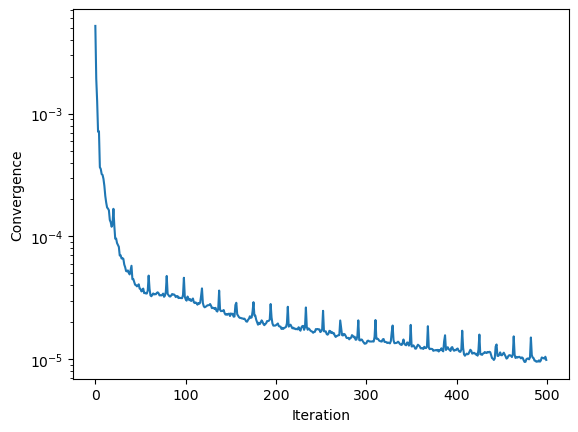

In [55]:
plt.plot(output['convergence'])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Convergence')

In [56]:
stokes = ['I', 'Q', 'U']

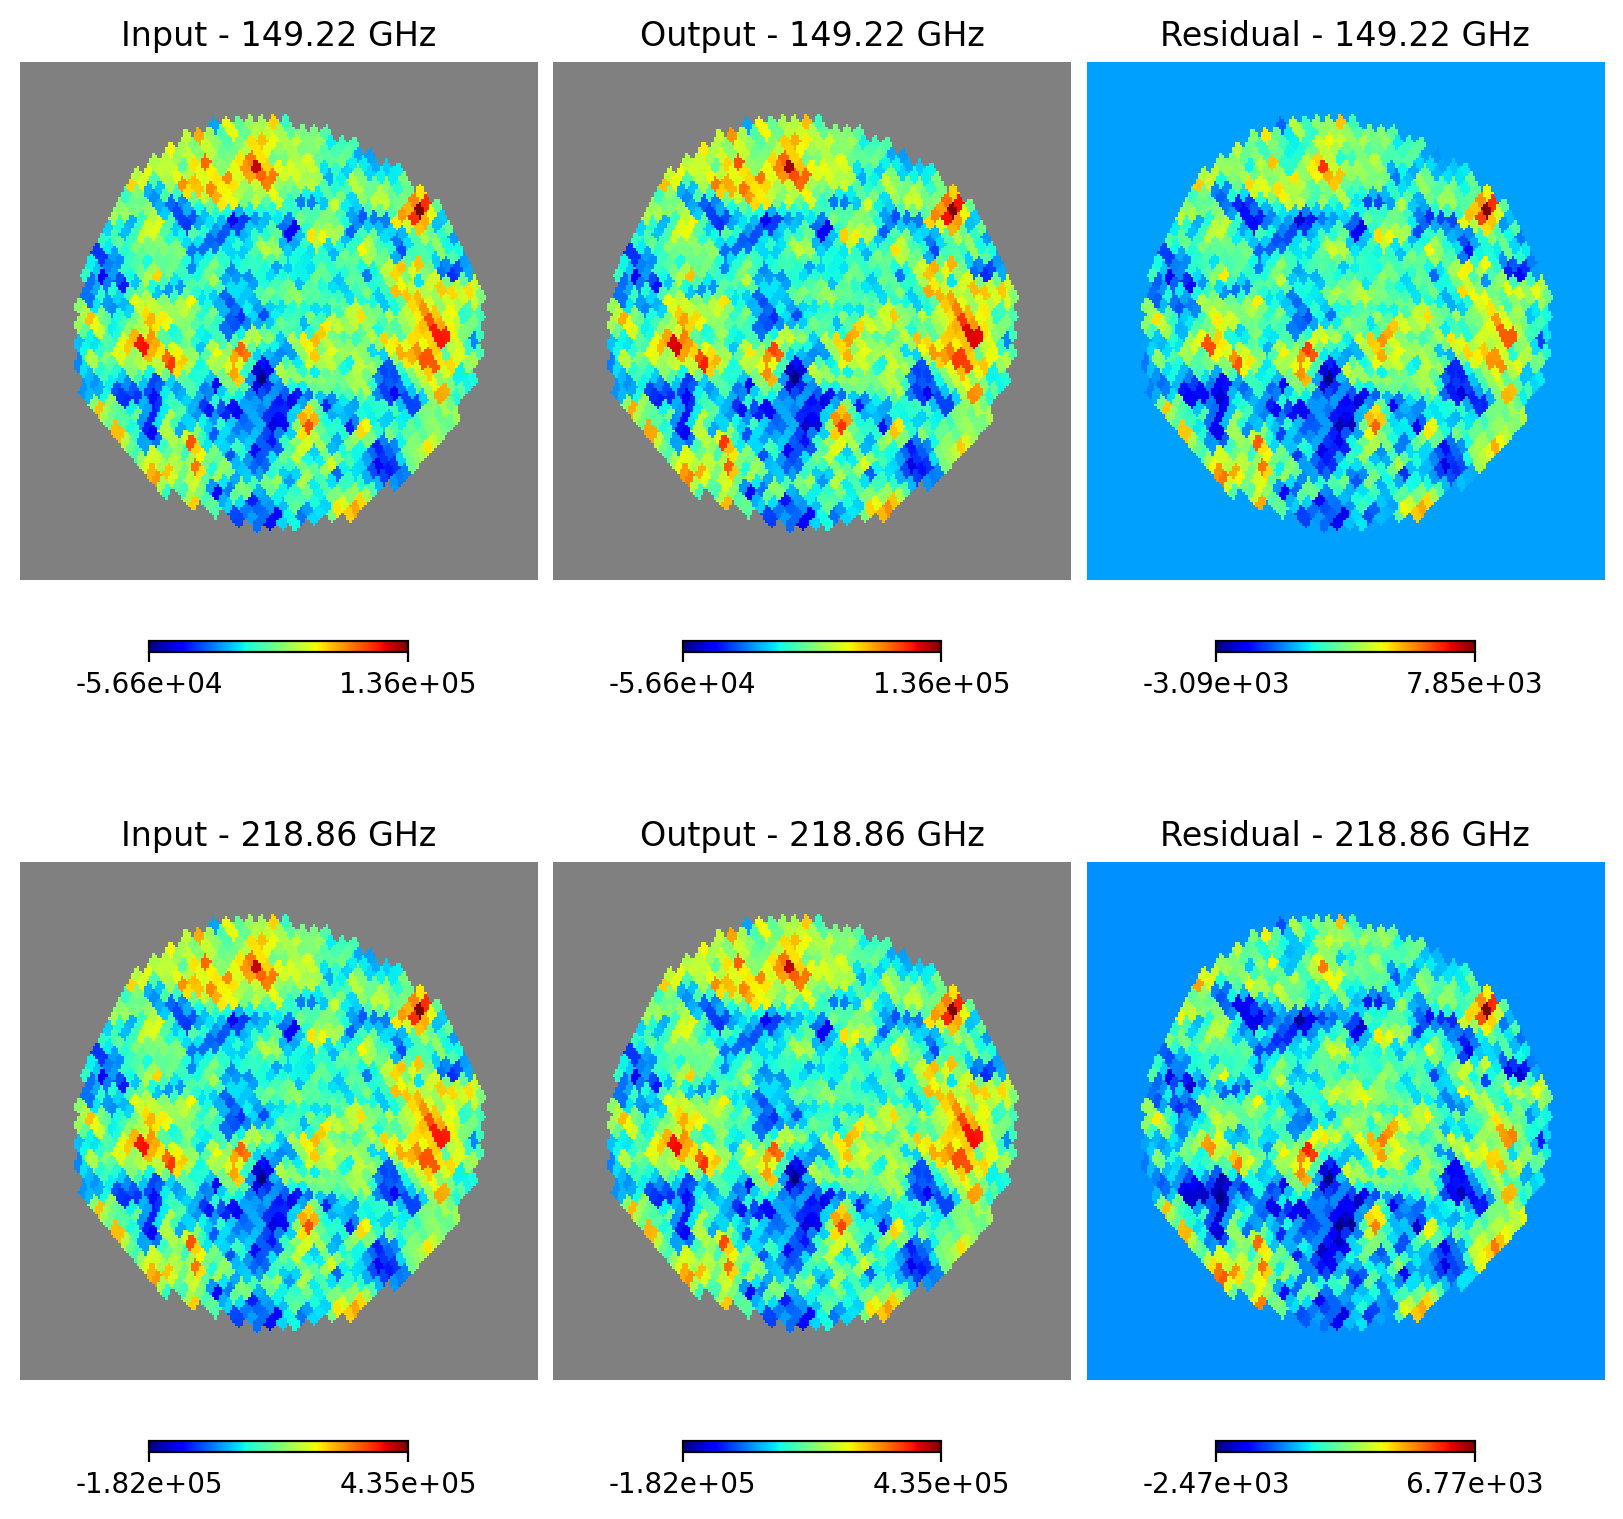

In [57]:

plt.figure(figsize=(8, 8), dpi=200)
k=1
true_maps[:, ~seenpix, :] = hp.UNSEEN
output['x'][:, ~seenpix, :] = hp.UNSEEN

istk = 0
n_sig = 3
reso = 15

for inu in range(output['x'].shape[0]):
    sigma = np.std(true_maps[inu, seenpix, istk])
    hp.gnomview(true_maps[inu, :, istk], min=np.min(true_maps[inu, seenpix, istk]), max=np.max(true_maps[inu, seenpix, istk]), cmap='jet', rot=qubic_patch,title='Input - {:.2f} GHz'.format(true_frequencies[inu]), reso=reso, sub=(output['x'].shape[0], 3, k), notext=True)
    hp.gnomview(output['x'][inu, :, istk], min=np.min(true_maps[inu, seenpix, istk]), max=np.max(true_maps[inu, seenpix, istk]), cmap='jet', rot=qubic_patch,title='Output - {:.2f} GHz'.format(true_frequencies[inu]), reso=reso, sub=(output['x'].shape[0], 3, k+1), notext=True)
    hp.gnomview(output['x'][inu, :, istk] - true_maps[inu, :, 0], cmap='jet', rot=qubic_patch,title='Residual - {:.2f} GHz'.format(true_frequencies[inu]), reso=reso, sub=(output['x'].shape[0], 3, k+2), notext=True)
    k+=3

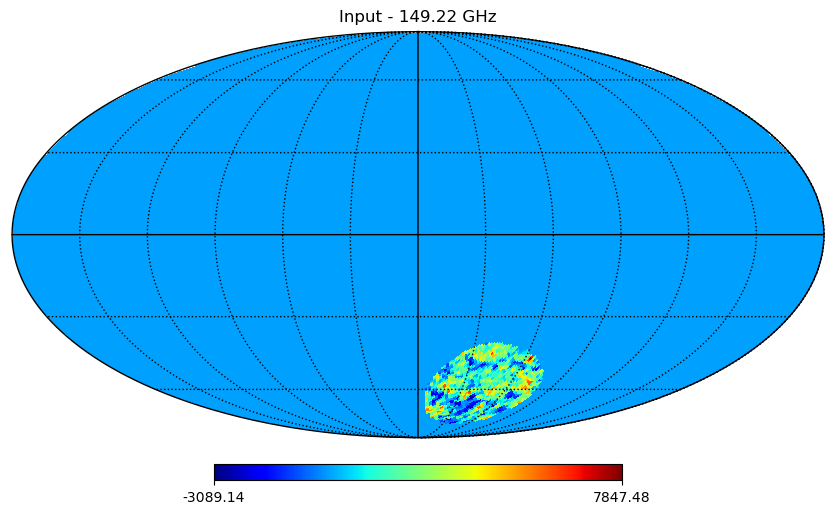

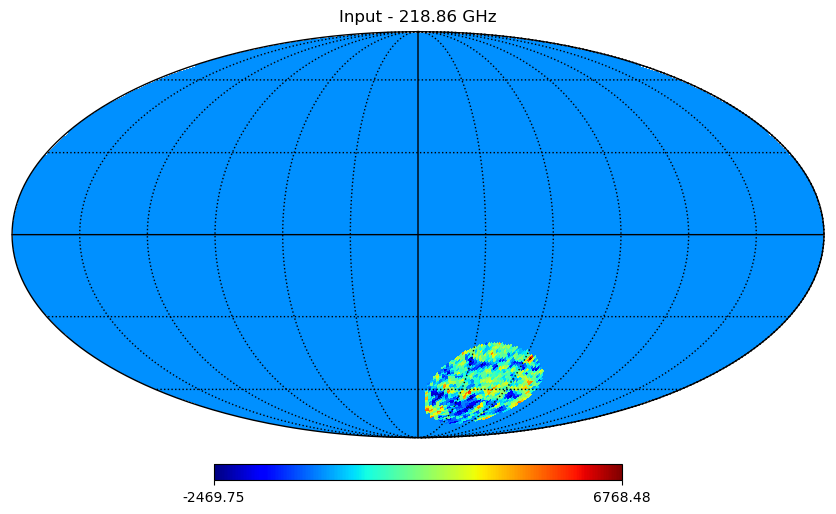

In [58]:
for inu in range(output['x'].shape[0]):
    sigma = np.std(true_maps[inu, seenpix, istk])
    hp.mollview(output['x'][inu, :, istk] - true_maps[inu, :, istk], cmap='jet',title='Input - {:.2f} GHz'.format(true_frequencies[inu]))
    hp.graticule()

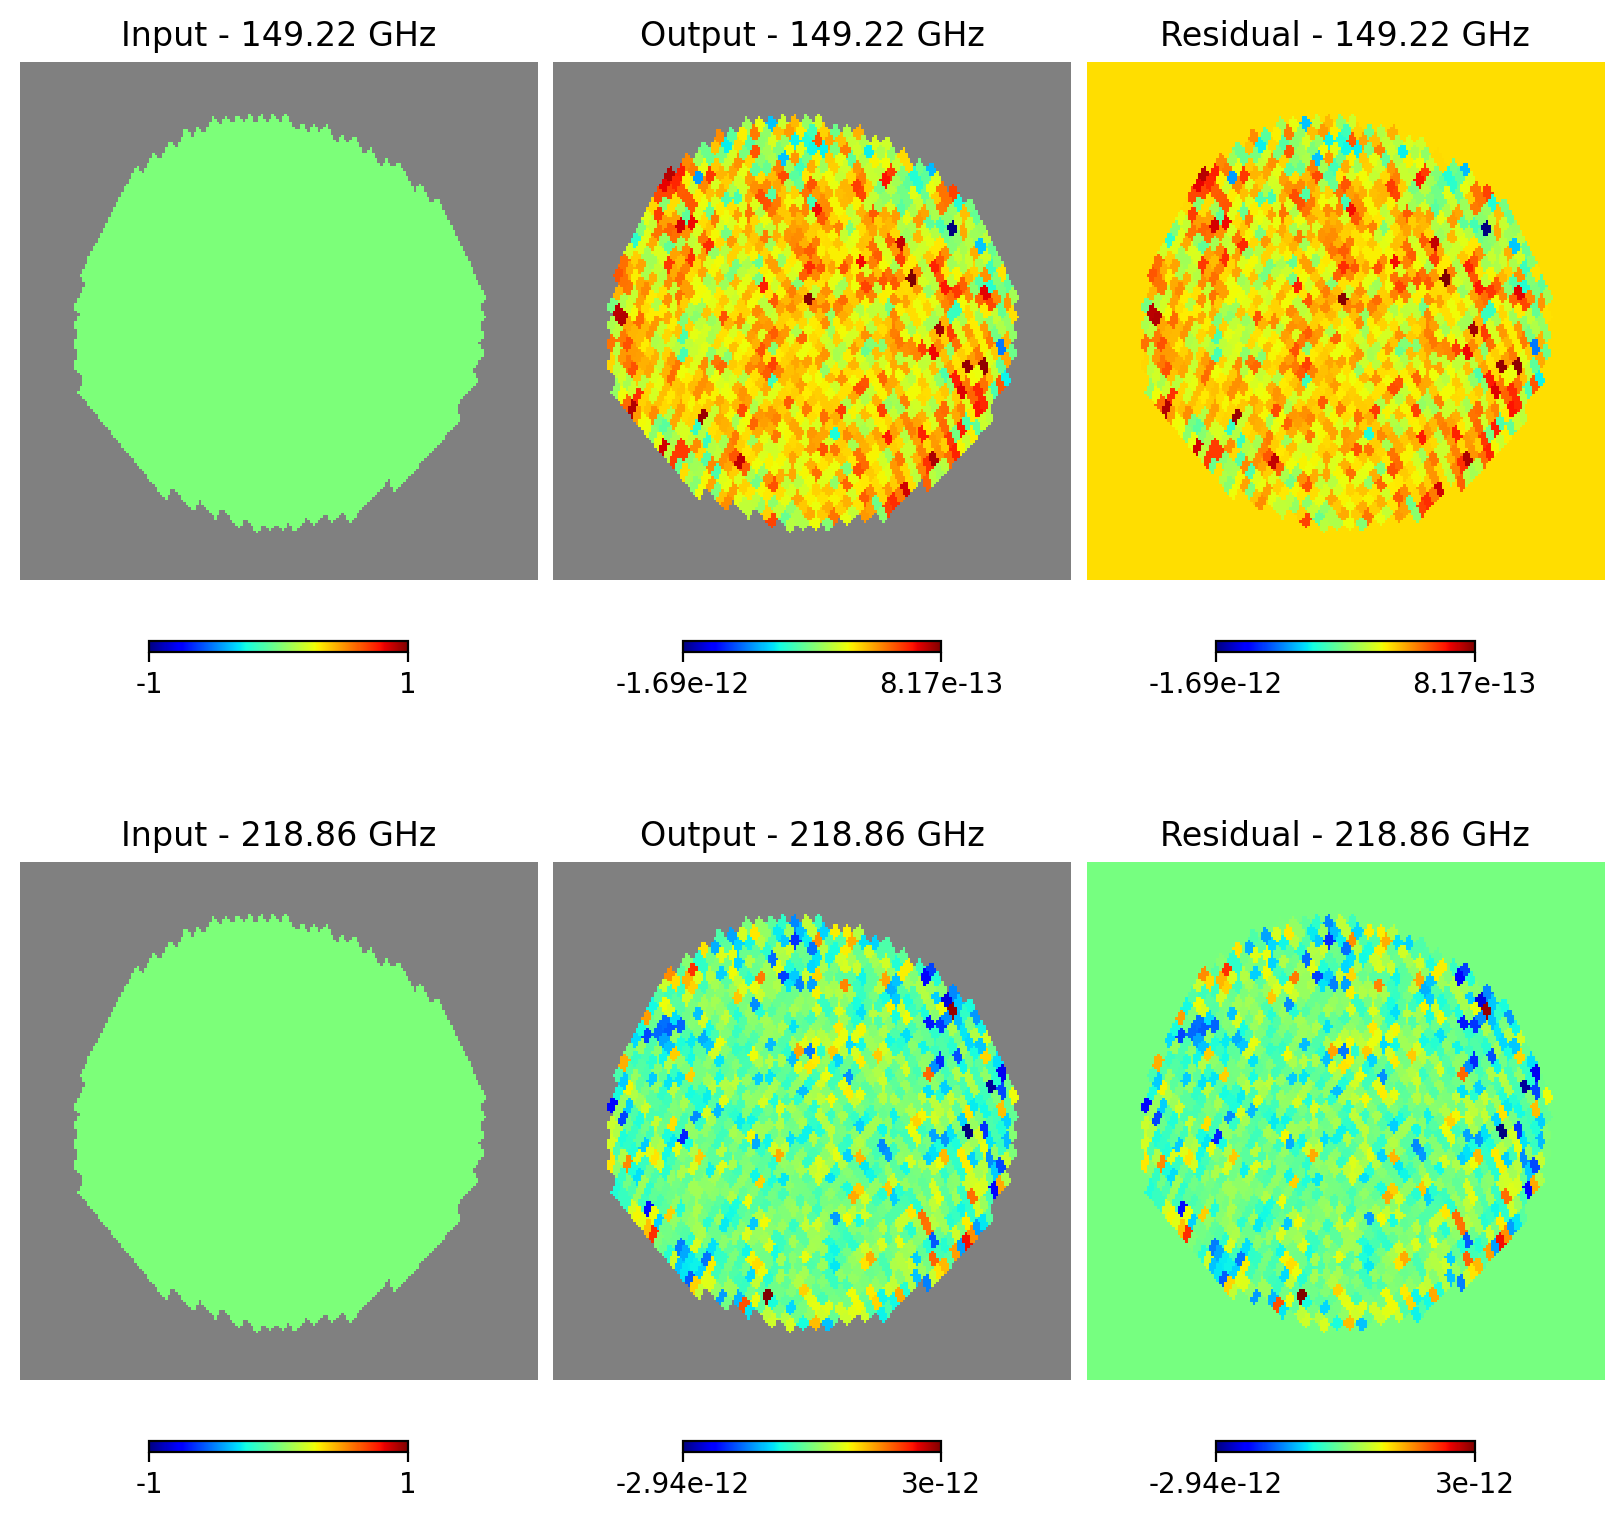

In [59]:
plt.figure(figsize=(8, 8), dpi=200)

k=1
true_maps[:, ~seenpix, :] = hp.UNSEEN
output['x'][:, ~seenpix, :] = hp.UNSEEN

istk = 1
n_sig = 2

for inu in range(output['x'].shape[0]):
    sigma = np.std(true_maps[inu, seenpix, istk])
    hp.gnomview(true_maps[inu, :, istk], cmap='jet', rot=qubic_patch,title='Input - {:.2f} GHz'.format(true_frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k), notext=True)
    hp.gnomview(output['x'][inu, :, istk], cmap='jet', rot=qubic_patch,title='Output - {:.2f} GHz'.format(true_frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k+1), notext=True)
    hp.gnomview(output['x'][inu, :, istk] - true_maps[inu, :, istk], cmap='jet', rot=qubic_patch,title='Residual - {:.2f} GHz'.format(true_frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k+2), notext=True)
    k+=3

In [60]:
stop

NameError: name 'stop' is not defined